Mount your Google drive (to access data)

In [1]:
from google.colab import drive

drive.mount('/content/drive')

# Go to target directory
%cd /content/drive/MyDrive/course/lics-exp2-3DV-Fall-main/code/

Mounted at /content/drive
/content/drive/MyDrive/course/lics-exp2-3DV-Fall-main/code


Include required packages before using them

In [2]:
import cv2 # for processing images
import numpy as np # for matrix manipulation
import glob # for accessing path
import matplotlib.pyplot as plt # for general visualization
import plot # custom visualization
import copy
import yaml # for loading yaml files

Load Data

Intrinsic paramters K:
 [[350.    0.  214. ]
 [  0.  350.  285.5]
 [  0.    0.    1. ]]

 Distortion coefficients:
 [[0.]
 [0.]
 [0.]
 [0.]]


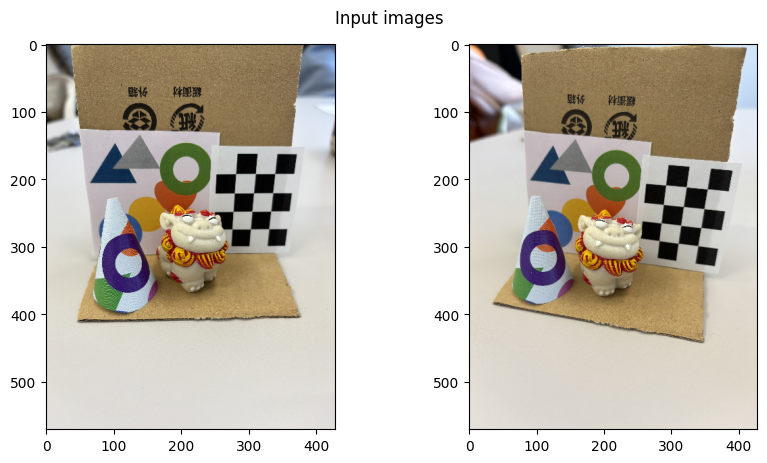

In [3]:
def load_camera_data(filename):
    try:
        with open(filename, 'r') as f:
            data = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None

    # Intrinsic parameters
    K = np.array(data["camera_intrinsic_K"], dtype=np.float64)

    # Distortion coefficient
    D = np.array(data["distortion_coeffs_D"], dtype=np.float64).reshape(-1, 1)

    return K, D

# Read Image
img_left = cv2.imread('../data/stereo_001_rescale.png', cv2.IMREAD_COLOR_RGB) #left image
img_right = cv2.imread('../data/stereo_002_rescale.png', cv2.IMREAD_COLOR_RGB) #right image

# if images are not found
if img_left is None or img_right is None:
    print("Error: Could not load images.")
    exit()

# Get camera data
K, D = load_camera_data('camera_info.yaml')
image_size = img_left.shape[::-1] # (width, height)

print(f"Intrinsic paramters K:\n {K}\n\n Distortion coefficients:\n {D}")

# Visualization
plot.plotfigure([img_left, img_right], title='Input images')

#### Step 1: Extrinsic Calibration (Relative Pose Estimation)

**INPUT:**
* 2 images containing a checkerboard
* Intrinsic parameters **K**, Distortion Coefficients **D**

**OUTPUT:**
* Relative Rotation Matrix **R_2to1 (3x3)**
* Relative Translation Vector **T_2to1 (3x1)**

**Reference:** https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

In [ ]:
def calibration(img_left, img_right, K, D, image_size, checkerboard_size):
    """Compute relative pose from Camera 2 to Camera 1."""

    # ...Your code goes from here....

    # a. Define 3D coordinates of checkerboard (object points)
    # ... you can use np.zeros((height, width)) to initialize a zero-value matrix....
    objp =

    # b. Detect 2D checkerboard corners in images (image points)
    # .... Please also visualize the detected corners using cv2.drawChessboardCorners()

    # c. Estimate relative poses from world to camera 1 (R_wto1, T_wto1)
    #    and world to camera 2 (R_wto2, T_wto2) using cv2.solvePnP()
    # ....remember to convert from rotation vector to 3x3 rotation matrix using cv2.Rodrigues()


    # d. Use [R_wto1, T_wto1] and [R_wto2, T_wto2] to compute the relative pose
    #    from camera 2 to 1: R_2to1, T_2to1


    # For corner visualization: transform corner points into camera 1 space
    objp_c = (R_wto1 @ objp.T) + T_wto1

    return R_2to1, T_2to1, objp_c

In [ ]:
R_2to1, T_2to1, objp_c = calibration(img_left, img_right, K, D, image_size, checkerboard_size=(3, 4))

# Visualize the cameras in 3D Space
plot.plot_cameras_with_points([np.eye(3), R_2to1], [np.zeros((3, 1)), T_2to1], K, points3D=objp_c.T, colors=None)

#### Step 2: Image Rectification

**INPUT:**
* 2 images: img_left, img_right
* Intrinsic parameters **K**
* Relative Pose: **R_2to1 (3x3), T_2to1 (3x1)**

**OUTPUT:**
* Rectified Images: **rectified_L, rectified_R**

In [ ]:
def rectify_images(img_left, img_right, K, R_2to1, T_2to1):
    """Make the two images 'horizontally aligned' """

    # ...Your code goes from here....
    # a. Define new camera axes R_rec
    # .... you can use np.linalg.norm() to obtain the length of a vector
    R_rec = np.zeros((3, 3))
    R_rec[0, :] = # x-axis

    R_rec[1, :] = # y-axis

    R_rec[2, :] =  # z-axis

    # b. Compute the Homograpy matrices: H_1, H_2
    H_1 =
    H_2 =

    # c. Warp the images: rectified_L, rectified_R
    rectified_L =
    rectified_R =

    return R_rec, rectified_L, rectified_R

In [ ]:
R_rec, rectified_L, rectified_R = rectify_images(img_left, img_right, K, R_2to1, T_2to1)

# Visualization
plot.plotfigure([img_left, img_right], title='Original images')
plot.plotfigure([rectified_L, rectified_R], title='Rectified images')

#### Step 3: Correspondence Search (Disparity Map)

**INPUT:**
* Rectified Images: rectified_L, rectified_R

**OUTPUT:**
* Disparity Map


**Reference:** https://github.com/grzlr/bm_sgbm/blob/master/src/sgbm.py

In [ ]:
def compute_disparity_map(rectified_L, rectified_R):
    """Computes the pixel shift (disparity)."""

    # ...Your code goes from here....
    # using cv2.StereoSGBM_create()
    #----------------------------------
    # SGBM params = {
        # minDisparity = 10 # far
        # numDisparities = 128 # close -> detectable depth range, must be divisible by 16
        # blockSize = 5 # odd num, between 3 and 11
        # P1 = 8 * 1 * blockSize**2 # smoothness control: P2 > P1
        # P2 = 32 * 1 * blockSize**2
        # disp12MaxDiff=1,      # Maximum difference between left/right disparity check
        # uniquenessRatio=15,   # Margin in percentage by which the best cost should beat the second best
        # speckleWindowSize=150,# Window size for speckle elimination
        # speckleRange=32, # Maximum disparity variation in a connected component
    #}
    #----------------------------------

    # a. Initialize the SGBM matcher
    stereo =

    # b. Compute disparity -> 16-bit signed int
    disparity_map =

    # c. Convert to float (astype(np.float32)) and scale (divided by 16.0) for visualization


    # d. Filter out invalid values
    disparity_float[disparity_map <= minDisparity] = 0

    return disparity_map

In [ ]:
disparity_map = compute_disparity_map(rectified_L, rectified_R)

# Visualization
plt.imshow(disparity_map)
plt.colorbar() # show the scale
plt.show()

#### Step 4: Depth Estimation

**INPUT:**
* Disparity Map
* Intrinsic K
* Relative Translation vector T_2to1

**OUTPUT:**
* Depth Map

In [ ]:
def disparity_to_depth(disparity_map, K, T_2to1, mask=None):
  """Computes depth from disparity."""

  # ...Your code goes from here....

  # a. Get the focal length and the length of baseline (i.e., length of T_2to1)
  focal_length =
  baseline =

  # b. Compute depth from disparity
  depth_map =


  return depth_map

In [ ]:
depth_map = disparity_to_depth(disparity_map, K, T_2to1)

# Visualization
plt.imshow(depth_map, cmap='jet')
plt.colorbar() # show the scale
plt.show()

#### Step 5: Depth to 3D point cloud

**INPUT:**
* Depth Map
* Intrinsic **K**, New camera axes **R_rec**
* (rectified_L $\rightarrow$ for accessing colors)

**OUTPUT:**
* 3D colored point cloud

In [ ]:
def depth_to_pointcloud3D(depth_map, K, R_rec, rectified_L, color):
  """Computes 3D point cloud from depth."""

  # a. Prepare 2d image coordinate matrix -> point2d (u, v, 1)
  v_coords, u_coords = np.indices((depth_map.shape[0], depth_map.shape[1]), dtype=np.float32)
  u_flat = u_coords.flatten() # (N,)
  v_flat = v_coords.flatten() # (N,)
  ones_row = np.ones(u_flat.size, dtype=np.float32) # last row
  point2d = np.vstack([u_flat, v_flat, ones_row]) #(3, N)

  # ...Your code goes from here....
  # b. Transform to camera space using inverse of K, inverse matrix can be obtained by np.linalg.inv(K)
  point3d =

  # c. Multiply depth Z


  # d. Assign color for each point


  # e. Transform back to original camera 1 frame using the transpose of R_rec



  # f. Optional: filter out outlier/noisy points
  # .... for example, remove points whose depth Z is either too far from or too close to the camera.....
  Z_MIN, Z_MAX, X_MAX, Y_MIN = 8, 14, 5, -5
  valid_depth_mask = (point3d[:, 2] > Z_MIN) & (point3d[:, 2] < Z_MAX) & (point3d[:, 0] < X_MAX) & (point3d[:, 1] > Y_MIN)
  colors = color[valid_depth_mask]
  filtered_point3d = point3d[valid_depth_mask]

  return filtered_point3d, colors

In [ ]:
point_cloud3D, colors = depth_to_pointcloud3D(depth_map, K, R_rec, rectified_L, color=img_left.reshape(-1, 3))

# Visualize the 3D colored point cloud and cameras in 3D Space
plot.plot_cameras_with_points([np.eye(3), R_2to1], [np.zeros((3, 1)), T_2to1], K, points3D=point_cloud3D, colors=colors)